<a href="https://colab.research.google.com/github/fajemila/yorubanlptoen/blob/main/yortranslation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchtext==0.6.0

     |████████████████████████████████| 71kB 6.7MB/s 
     |████████████████████████████████| 1.2MB 12.6MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.data import Field, BucketIterator
import string
import spacy
from torchtext import data

import numpy as np

import pandas
import random
import math
import time

In [4]:
import torchtext
torchtext.__version__

'0.6.0'

In [5]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
spacy_en = spacy.load('en')

In [7]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]
tokenize_yr = lambda x: str(x).translate(str.maketrans('', '', string.punctuation)).strip().split()

In [8]:
ID = Field()
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True,
            fix_length=50)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True,
            fix_length=50)

In [9]:
from torchtext import data
tv_datafields = [('ID', None),("Yoruba", SRC), ("English", TRG)]
train_data = data.TabularDataset(path='drive/MyDrive/yorubatoEN/Train.csv',format="csv",
                                                skip_header=True, fields =tv_datafields)
test_data = data.TabularDataset(path='drive/MyDrive/yorubatoEN/Test.csv', format="csv",
                                                skip_header=True, fields =[('ID', None),("Yoruba", SRC)])

In [10]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 10054
Number of testing examples: 6816


In [11]:
print(vars(train_data.examples[0]))

{'Yoruba': ['a', 'ṣètò', 'ìgbìmọ̀', 'tó', 'ń', 'ṣètò', 'ìrànwọ́', 'nígbà', 'àjálù', 'láti', 'wá', 'bí', 'àwọn', 'ará', 'wa', 'níbẹ̀', 'ṣe', 'máa', 'rí', 'àwọn', 'nǹkan', 'tí', 'wọ́n', 'máa', 'nílò', 'lọ́jọ́', 'iwájú', '.'], 'English': ['a', 'disaster', 'relief', 'committee', 'was', 'formed', 'to', 'organize', 'the', 'long', '-', 'term', 'relief', 'efforts', '.']}


In [12]:
import random

train_data, valid_data = train_data.split(split_ratio=0.9,random_state = random.seed(SEED))

In [13]:
SRC.build_vocab(train_data, max_size =10000)
TRG.build_vocab(train_data, max_size =10000)

In [14]:
SRC.pad_token

'<pad>'

In [15]:
TRG.pad_token

'<pad>'

In [16]:
print(f"Unique tokens in source (yr) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (yr) vocabulary: 10004
Unique tokens in target (en) vocabulary: 10004


In [ ]:
def save_vocab(vocab,path):
    import pickle
    output = open(path,'wb')
    pickle.dump(vocab,output)
    output.close

In [ ]:
save_vocab(SRC.vocab,'srcvocab.pkl')
save_vocab(TRG.vocab,'trgvocab.pkl')

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
train_iter , valid_iter = data.BucketIterator.splits((train_data,valid_data), device=device, 
                                 batch_sizes=(1,1),
                                 sort_key = lambda x: data.interleave_keys(len(x.Yoruba),len(x.English)),
                                 sort_within_batch=True, repeat=False)
test_iter = data.Iterator(test_data,batch_size=16,device=device,train=False,sort=False,sort_within_batch=False)

In [30]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 50):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [31]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [32]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [33]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [34]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 50):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [35]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [36]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [58]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 6
DEC_LAYERS = 1
ENC_HEADS = 4
DEC_HEADS = 4
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [59]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [60]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,672,084 trainable parameters


In [61]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [62]:
model.apply(initialize_weights);

In [63]:
LEARNING_RATE = 0.0001

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [64]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.Yoruba
        trg = batch.English
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [65]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.Yoruba
            trg = batch.English

            output, _ = model(src, trg[:,:-1])
        
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [66]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [67]:
N_EPOCHS = 10
CLIP = 1
from torch.nn import functional as F
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iter, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 6m 24s
	Train Loss: 5.760 | Train PPL: 317.379
	 Val. Loss: 5.036 |  Val. PPL: 153.795
Epoch: 02 | Time: 6m 25s
	Train Loss: 4.809 | Train PPL: 122.649
	 Val. Loss: 4.747 |  Val. PPL: 115.231
Epoch: 03 | Time: 6m 26s
	Train Loss: 4.371 | Train PPL:  79.158
	 Val. Loss: 4.654 |  Val. PPL: 105.054
Epoch: 04 | Time: 6m 32s
	Train Loss: 4.040 | Train PPL:  56.800
	 Val. Loss: 4.579 |  Val. PPL:  97.444
Epoch: 05 | Time: 6m 30s
	Train Loss: 3.764 | Train PPL:  43.132
	 Val. Loss: 4.601 |  Val. PPL:  99.543


KeyboardInterrupt: ignored

In [68]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss = evaluate(model, valid_iter, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.579 | Test PPL:  97.444 |


In [69]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()

    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [70]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    attention = attention.squeeze(0).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [71]:
example_idx = 5

src = vars(train_data.examples[example_idx])['Yoruba']
trg = vars(train_data.examples[example_idx])['English']

print(f'Yoruba = {src}')
print(f'English = {trg}')

Yoruba = ['àwọn', 'afẹ̀hónúhàn', 'kóra', 'jọ', 'láti', 'fi', 'òpin', 'sí', 'ikọ̀', 'sars', 'ní', 'ọjọ́', '13', ',', 'oṣù', 'òwàrà', ',', 'ọdún', '2020', ',', 'ní', 'ikeja', ',', 'èkó', '.']
English = ['protesters', 'gather', 'to', 'end', 'sars', 'on', 'october', '13', ',', '2020', ',', 'in', 'ikeja', ',', 'lagos', '.']


In [72]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted English = {translation}')

predicted English = ['the', 'president', 'of', 'the', 'president', 'muhammadu', 'buhari', 'has', 'been', 'of', 'the', 'super', 'eagles', ',', 'who', 'is', 'the', 'world', 'cup', 'in', 'the', 'world', 'cup', 'in', 'the', 'world', 'cup', 'in', 'the', 'world', 'cup', '.', '<eos>']


TypeError: ignored

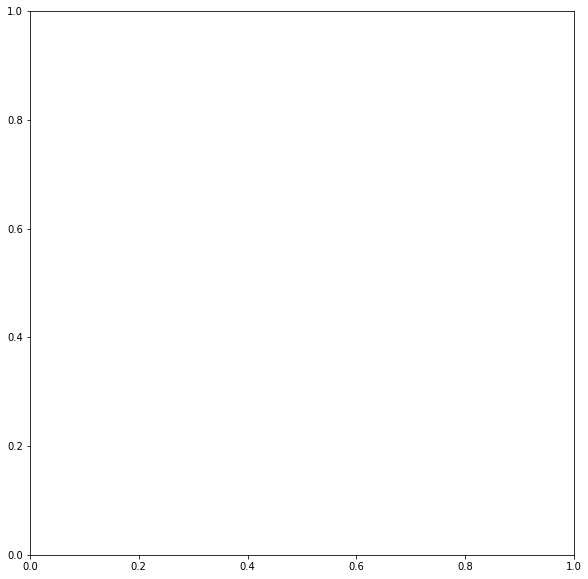

In [73]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

display_attention(src, translation, attention)

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['Yoruba']
        trg = vars(datum)['English']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(valid_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 3.52


In [74]:
trgs = []
pred_trgs = []

for datum in test_data:
    
    src = vars(datum)['Yoruba']
    if len(src)>48:
      src= src[:48]
    pred_trg, _ = translate_sentence(src, SRC, TRG, model, device, 50)
    
    #cut off <eos> token
    pred_trg = pred_trg[:-1]
    
    pred_trgs.append(pred_trg)    

In [75]:
import pandas as pd
test = pd.read_csv('drive/MyDrive/yorubatoEN/Test.csv')
test.head()

,ID,Yoruba
0,ID_AAAitMaH,"Nínú ìpè kan lẹ́yìn ìgbà náà, wọ́n sọ fún aṣoj..."
1,ID_AAKKdQwr,Nítorí kò sí nǹkan tí ọkùnrin ò lè ṣe láì náán...
2,ID_ABgAyEOp,Bí i kó pariwo. Kí ó kígbe mọ́ ẹ?
3,ID_ACFgfKQs,"Tí ó ń lé e lọ sọ́nà etí odò Akókurà, tí ó bẹ̀..."
4,ID_ACNPmlhf,Èṣúńiyì mọ̀ iṣẹ́ rẹ̀ dunjú. Màmá tirí bí ó ṣe ...


In [76]:
test['English'] = pred_trgs

In [77]:
test.head()

,ID,Yoruba,English
0,ID_AAAitMaH,"Nínú ìpè kan lẹ́yìn ìgbà náà, wọ́n sọ fún aṣoj...","[we, are, confident, that, jehovah, will, cont..."
1,ID_AAKKdQwr,Nítorí kò sí nǹkan tí ọkùnrin ò lè ṣe láì náán...,"[i, do, n't, know, that, i, want, to, know, ho..."
2,ID_ABgAyEOp,Bí i kó pariwo. Kí ó kígbe mọ́ ẹ?,"[what, is, the, person, who, is, the, <unk>, o..."
3,ID_ACFgfKQs,"Tí ó ń lé e lọ sọ́nà etí odò Akókurà, tí ó bẹ̀...","[“, we, are, not, to, be, able, to, see, you, ..."
4,ID_ACNPmlhf,Èṣúńiyì mọ̀ iṣẹ́ rẹ̀ dunjú. Màmá tirí bí ó ṣe ...,"[it, is, the, <unk>, that, one, 's, own, child..."


In [78]:
test['English'] = [' '.join(map(str, l)) for l in test['English']]

In [79]:
test.head()

,ID,Yoruba,English
0,ID_AAAitMaH,"Nínú ìpè kan lẹ́yìn ìgbà náà, wọ́n sọ fún aṣoj...",we are confident that jehovah will continue to...
1,ID_AAKKdQwr,Nítorí kò sí nǹkan tí ọkùnrin ò lè ṣe láì náán...,i do n't know that i want to know how to prote...
2,ID_ABgAyEOp,Bí i kó pariwo. Kí ó kígbe mọ́ ẹ?,what is the person who is the <unk> of the <un...
3,ID_ACFgfKQs,"Tí ó ń lé e lọ sọ́nà etí odò Akókurà, tí ó bẹ̀...","“ we are not to be able to see you , ” is the ..."
4,ID_ACNPmlhf,Èṣúńiyì mọ̀ iṣẹ́ rẹ̀ dunjú. Màmá tirí bí ó ṣe ...,it is the <unk> that one 's own child .


In [80]:
test[['ID','English']].to_csv('yorsolution.csv',index=False)